In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg")
%matplotlib inline

import pathlib
from pathlib import Path
import matplotlib.pyplot as plot
import librosa
import tensorflow as tf
import keras
from keras import regularizers
from keras.models import load_model, Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
    
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from numpy import argmax
from imutils import paths
import numpy as np

from datetime import datetime
import pickle, random, os, sys, json, re, getopt, warnings

#Visualization
import seaborn as sn
import pandas as pd

#env parameters
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [2]:
#Parameters
#Folders
data_folder = Path("../../../audio/testfiles/GTZAN/genres/")
output_root = './../../../models/'
output_folder = Path('./output/cvnn_16-3.model')
output_model = output_root + '/cnn_dong_model_weights.h5'
output_architecture = output_root + '/cnn_dong_model_architecture.json'
output_whole = output_root + 'cnn_dong_model_whole.h5'
output_best_model = output_root + 'best_model.h5'
output_label = output_root + 'label.pkl'
output_test_paths = output_root + 'test_paths.pkl'

# Duration of songsnippet in seconds
duration = 2.97
start_offset = 0
epochs = 400
num_segments = 19

batch_size = 64

es_patience = 20
return_train_and_test = 1

sr = 22050 # Sampling rate

#Parameters for mel spec
fmax = 1500 # maximum frequency considered
fft_points = 512
fft_dur = fft_points * 1.0 / sr # 23ms windows
hop_size = int(fft_points/ 2) # 50% overlap between consecutive frames
n_mels = 64

#Segment duration
num_fft_windows = 256 #per Segment
segment_in_points = num_fft_windows * 255
segment_dur = segment_in_points * 1.0 / sr

input_shape=(64, 256, 1)

randomseed = 11
#randomseed = datetime.now()
# Seed for RNG
random.seed(randomseed)


In [3]:
#Get directories of all songs
songs = []
genres = []

for g in data_folder.iterdir():
    genres.append(g.name)
    for i in g.iterdir():
        songs.append(i)

In [4]:
#shuffle songs to keep segements together
random.shuffle(songs)
print("[Info]: Loaded and shuffled " + str(len(songs)) + " songs from " + str(len(genres)) + " genres.")

[Info]: Loaded and shuffled 1000 songs from 10 genres.


In [5]:
#loading with different numbers of segements for data-augmentation
#!Initialize "spectograms" before running
def load_specs(data = songs, num_segments = 1):
    spectograms = []
    for song in data:
        offset = start_offset
        for i in range(num_segments):
            y, sr = librosa.load(song, mono=True, offset=offset, duration=duration)
            m_sp = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=fft_points,
                                                  hop_length=hop_size, n_mels=n_mels,
                                                  fmax=fmax)
            label = song.parts[-2]
            spectograms.append( (m_sp, label, song, offset, duration) )
            offset = offset + duration/2
        input_shape = m_sp.shape + (1,)
    return spectograms

In [6]:
print("[Info]: Generating Spectograms for " + str(num_segments) + " segments per song.")
spectograms = load_specs(data = songs, num_segments = num_segments)
labels = []
for i in spectograms:
    labels.append(i[1]) 

[Info]: Generating Spectograms for 19 segments per song.


In [7]:
print("[Info]: Total number of samples: ", len(input_shape))

#Set dynamic input shape
input_shape = np.shape(spectograms[0][0]) + (1,)
print("Input shape: " + str(input_shape))

[Info]: Total number of samples:  3
Input shape: (64, 256, 1)


In [8]:
print("[Info]: Splitting into train and testing data.")
#Split into Train and Testing
testsplit = len(spectograms)*0.7    #70% train-test-split
train = spectograms[:int(testsplit)]
test = spectograms[int(testsplit):]

x_train, y_train, p_train, offset_train, duration_train = zip(*train)
x_test, y_test, p_test, offset_test, duration_test = zip(*test)

#Fit Dimensions
x_train = np.array([x.reshape(input_shape) for x in x_train])
x_test = np.array([x.reshape(input_shape) for x in x_test])

[Info]: Splitting into train and testing data.


In [9]:
#Binarize Labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)


In [10]:
def dump_testspecs_labels():
    with open(output_label, 'wb') as f:
        pickle.dump(lb, f)

    if return_train_and_test == 1:
        r_paths = p_test + (p_train)
        r_offsets = offset_test + (offset_train)
        r_durations = duration_test + (duration_train)
    else:
        r_paths = p_test
        r_offsets = offset_test
        r_durations = duration_test

    r_values = [r_paths, r_offsets, r_durations]

    with open(output_test_paths, 'wb') as f:
        pickle.dump(r_values, f)

In [11]:
print("[Info]: Dumping data for prediction.")
dump_testspecs_labels()

[Info]: Dumping data for prediction.


In [12]:
#model for GTZAN
def cnn_gtzan_model_build():

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu', kernel_regularizer=regularizers.l2(0.01),
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 4)))

    model.add(Conv2D(64, (3, 5), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPooling2D(pool_size=(2, 4)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
    model.add(Dropout(0.3))
    model.add(Dense(len(genres), activation='softmax'))
    model.compile(
        optimizer="Adam",
        loss="categorical_crossentropy",
        metrics=['accuracy'])
    print(model.summary)
    return model

def train_model():
    model = cnn_gtzan_model_build()

    callbacks = [EarlyStopping(monitor='val_loss', patience=es_patience),
                 ModelCheckpoint(filepath=output_best_model, monitor='val_loss', save_best_only=True)]

    H = model.fit(
        x=x_train, 
        y=y_train,
        epochs=epochs,
        callbacks=callbacks,
        batch_size=batch_size,
        validation_data= (x_test, y_test))

    score = model.evaluate(x=x_test,y=y_test)

    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    return (model, H)

def save_model():
    # Save the weights
    model.save_weights(output_model)

    # Save the model architecture
    with open(output_architecture, 'w') as f:
        f.write(model.to_json())

    # Save complete model
    model.save(output_whole)

In [13]:
print("[Info]: Training model.")
model, history = train_model()

[Info]: Training model.
<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x7f6c631505f8>>
Train on 13300 samples, validate on 5700 samples
Epoch 1/400
13300/13300 [==============================] - 390s 29ms/step - loss: 2.9312 - acc: 0.2265 - val_loss: 2.2607 - val_acc: 0.2891
Epoch 2/400
13300/13300 [==============================] - 431s 32ms/step - loss: 2.1138 - acc: 0.3394 - val_loss: 1.9754 - val_acc: 0.3979
Epoch 3/400
13300/13300 [==============================] - 499s 38ms/step - loss: 1.9358 - acc: 0.3915 - val_loss: 1.8465 - val_acc: 0.4326
Epoch 4/400
13300/13300 [==============================] - 500s 38ms/step - loss: 1.8679 - acc: 0.4152 - val_loss: 1.7830 - val_acc: 0.4591
Epoch 5/400
13300/13300 [==============================] - 500s 38ms/step - loss: 1.8053 - acc: 0.4336 - val_loss: 1.7825 - val_acc: 0.4730
Epoch 6/400
13300/13300 [==============================] - 500s 38ms/step - loss: 1.7652 - acc: 0.4550 - val_loss: 1.7906 - val_acc

Epoch 58/400
13300/13300 [==============================] - 495s 37ms/step - loss: 1.4149 - acc: 0.6360 - val_loss: 1.6899 - val_acc: 0.5372
Epoch 59/400
13300/13300 [==============================] - 496s 37ms/step - loss: 1.4270 - acc: 0.6386 - val_loss: 1.6978 - val_acc: 0.5389
Epoch 60/400
13300/13300 [==============================] - 497s 37ms/step - loss: 1.4307 - acc: 0.6336 - val_loss: 1.5650 - val_acc: 0.5914
Epoch 61/400
13300/13300 [==============================] - 497s 37ms/step - loss: 1.4046 - acc: 0.6428 - val_loss: 1.6508 - val_acc: 0.5695
Epoch 62/400
13300/13300 [==============================] - 496s 37ms/step - loss: 1.4131 - acc: 0.6375 - val_loss: 1.5900 - val_acc: 0.5789
Epoch 63/400
13300/13300 [==============================] - 496s 37ms/step - loss: 1.4033 - acc: 0.6379 - val_loss: 1.5869 - val_acc: 0.5688
Epoch 64/400
13300/13300 [==============================] - 497s 37ms/step - loss: 1.4002 - acc: 0.6414 - val_loss: 1.5913 - val_acc: 0.5767
Epoch 65/400


In [14]:
print("[Info]: Saving model.")
save_model()

[Info]: Saving model.


In [15]:
def evaluate_song(song, model=model, duration=duration):
    start = 0
    r = 0
    for i in range(int(30/(duration/2))-1):
        y, sr = librosa.load(song, mono=True, offset=start, duration=duration)
        m_sp = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=fft_points,
                                              hop_length=hop_size, n_mels=n_mels,
                                              fmax=fmax)
        m_sp = np.expand_dims(m_sp, 0)
        m_sp = np.expand_dims(m_sp, 3)
        if r == 0:
            prediction = model.predict(m_sp)
            r = 1
        else:
            prediction = (prediction + model.predict(m_sp))/2
        start = start + duration/2
    return prediction
        
def evaluate_batch(batch):
    predictions = []
    for song in batch:
        predictions.append(evaluate_song(song))
    return predictions

def compare_batch(predictions):
    i = 0
    l = lb.inverse_transform(y_test)
    counter = 0
    for prediction in predictions:
        tr_value = str(l[i])
        pr_value = re.sub('[\[\]\']', '', str(lb.classes_[prediction.argmax(axis=1)]))
        print(tr_value + "=>" + pr_value)
        if tr_value == pr_value:
            counter += 1
        i += 1
    acc = counter/len(predictions)*100
    print("Acc: " + str(acc) + "%")

In [16]:
model = load_model(output_whole)

In [17]:
predictions = evaluate_batch(p_test)
compare_batch(predictions)

reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
hiphop=>disco
hiphop=>disco
hiphop=>disco
hiphop=>disco
hiphop=>disco
hiphop=>disco
hiphop=>disco
hiphop=>disco
hiphop=>disco
hiphop=>disco
hiphop=>disco
hiphop=>disco
hiphop=>disco
hiphop=>disco
hiphop=>disco
hiphop=>disco
hiphop=>disco
hiphop=>disco
hiphop=>disco
pop=>hiphop
pop=>hiphop
pop=>hiphop
pop=>hiphop
pop=>hiphop
pop=>hiphop
pop=>hiphop
pop=>hiphop
pop=>hiphop
pop=>hiphop
pop=>hiphop
pop=>hiphop
pop=>hiphop
pop=>hip

jazz=>blues
jazz=>blues
jazz=>blues
jazz=>blues
jazz=>blues
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
meta

blues=>metal
blues=>metal
blues=>metal
blues=>metal
blues=>metal
blues=>metal
blues=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
country=>country
hiphop=>hiphop
h

hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiphop=>hiphop
hiph

metal=>rock
metal=>rock
metal=>rock
metal=>rock
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
disco=>classical
disco=>classical
disco=>classical
disco=>classical
disco=>classical
disco=>classical
disco=>classical
disco=>classical
disco=>classical
disco=>classical
disco=>classical
disco=>classical
disco=>

jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
jazz=>jazz
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
blues=>blues
reggae=>hiphop
reggae=>hiphop
reggae=>hiphop
reggae=>hiphop
reggae=>hiphop
reggae=>hiphop
reggae=>hiphop
reggae=>hiphop
reggae=>hiphop
reggae=>hiphop
reggae=>hiphop
reggae=>hiphop
reggae=>hiphop
reggae=>hiphop
reggae=>hiphop
reggae=>hiphop
reggae=>hiphop
reggae=>hiphop
reggae=>hiphop
jazz=>blues
jazz=>blues
jazz=>blues
jazz=>blues
jazz=>blues
jazz=>blues
jazz=>blues
jazz=>blues
jazz=>blues
jazz=>blues
jazz=>blues
jazz=>blues
jazz=>blues
jazz=>blues
jazz=>blues
ja

pop=>pop
pop=>pop
pop=>pop
pop=>pop
pop=>pop
pop=>pop
pop=>pop
pop=>pop
pop=>pop
pop=>pop
pop=>pop
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
rock=>metal
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
reggae=>reggae
regg

hiphop=>metal
hiphop=>metal
hiphop=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
metal=>metal
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
classical=>classical
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
rock=>rock
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco
disco=>disco

In [18]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x_test, batch_size=batch_size)


# plot the training loss and accuracy
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure()

[INFO] evaluating network...


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [19]:
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1), 
                            target_names=lb.classes_))

              precision    recall  f1-score   support

       blues       0.42      0.49      0.45       418
   classical       0.72      0.96      0.82       475
     country       0.57      0.54      0.55       532
       disco       0.67      0.66      0.66       589
      hiphop       0.50      0.60      0.54       494
        jazz       0.58      0.68      0.63       646
       metal       0.55      0.81      0.65       627
         pop       0.80      0.56      0.66       627
      reggae       0.73      0.61      0.67       513
        rock       0.51      0.23      0.32       779

   micro avg       0.60      0.60      0.60      5700
   macro avg       0.60      0.61      0.60      5700
weighted avg       0.61      0.60      0.59      5700



In [20]:
cm = confusion_matrix(lb.inverse_transform(y_test), lb.classes_[predictions.argmax(axis=1)], lb.classes_)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.around(cm, decimals=2)
print(genres)
print(cm)
print(lb.classes_[predictions.argmax(axis=1)])

['rock', 'disco', 'country', 'reggae', 'jazz', 'classical', 'pop', 'blues', 'metal', 'hiphop']
[[0.49 0.01 0.03 0.01 0.   0.19 0.16 0.01 0.02 0.09]
 [0.   0.96 0.01 0.   0.   0.04 0.   0.   0.   0.  ]
 [0.05 0.02 0.54 0.07 0.   0.17 0.05 0.01 0.   0.09]
 [0.01 0.01 0.03 0.66 0.14 0.   0.06 0.04 0.04 0.01]
 [0.02 0.   0.   0.13 0.6  0.   0.08 0.08 0.08 0.01]
 [0.08 0.14 0.06 0.   0.   0.68 0.01 0.   0.02 0.01]
 [0.02 0.   0.01 0.01 0.04 0.   0.81 0.   0.   0.1 ]
 [0.06 0.03 0.03 0.04 0.18 0.05 0.02 0.56 0.02 0.01]
 [0.1  0.03 0.04 0.04 0.12 0.04 0.01 0.01 0.61 0.  ]
 [0.11 0.03 0.14 0.04 0.02 0.09 0.29 0.01 0.03 0.23]]
['reggae' 'reggae' 'reggae' ... 'jazz' 'jazz' 'jazz']


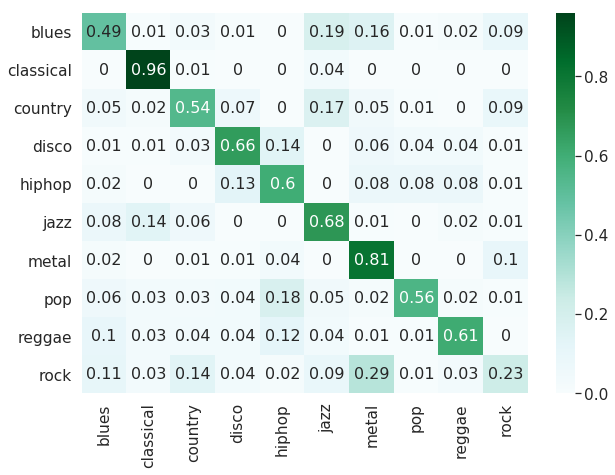

In [21]:
p_array = [[0.34,0.03,0.23,0.08,0.02,0.03,0.02,0.09,0.16,0.01],
 [0.02, 0.68, 0.02, 0.1 , 0.  , 0.01, 0.04, 0.02, 0.02, 0.08],
 [0.09, 0.04, 0.63, 0.03, 0.07, 0.02, 0.01, 0.1 , 0.01, 0.  ],
 [0.  , 0.03, 0.06, 0.67, 0.01, 0.02, 0.05, 0.12, 0.  , 0.04],
 [0.02, 0.  , 0.06, 0.02, 0.61, 0.1 , 0.01, 0.15, 0.02, 0.  ],
 [0.  , 0.  , 0.01, 0.  , 0.02, 0.97, 0.  , 0.  , 0.  , 0.  ],
 [0.02, 0.04, 0.03, 0.03, 0.03, 0.04, 0.58, 0.07, 0.02, 0.15],
 [0.09, 0.  , 0.06, 0.02, 0.07, 0.02, 0.02, 0.63, 0.09, 0.  ],
 [0.17, 0.03, 0.01, 0.01, 0.  , 0.  , 0.01, 0.04, 0.71, 0.03],
 [0.01, 0.12, 0.  , 0.08, 0.  , 0.  , 0.12, 0.02, 0.12, 0.54]]

df_cm = pd.DataFrame(cm, lb.classes_,
                  lb.classes_)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size

ax=sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap="BuGn")# font size

In [22]:
history

In [23]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


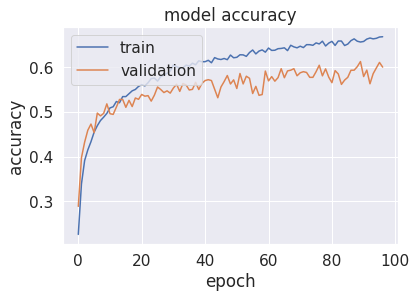

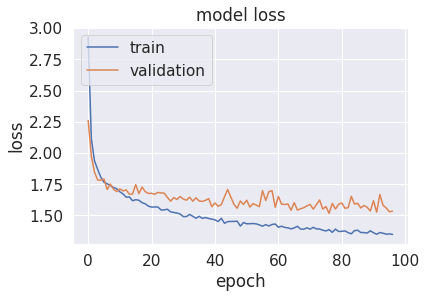

In [24]:
show_summary_stats(history)